In [1]:
from pychastic.problems.kp_4_27 import KloedenPlaten4_27
from pychastic.sde_solver import SDESolver
import pychastic
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import jax


# Exercise 9.3.4 / 10.3.2

In [4]:
a = 0.1
x0 = 0.5

problem = pychastic.sde_problem.SDEProblem(
  lambda x: -a**2*x*(1-x**2),
  lambda x: a*(1-x**2),
  x0 = x0,
  tmax=1,
  exact_solution = lambda x0, t, w: np.tanh(a*w+np.arctanh(x0))
)

solvers = [
  SDESolver(adaptive=False, scheme='euler'),
  SDESolver(adaptive=False, scheme='milstein'),
  SDESolver(adaptive=False, scheme='wagner_platen'),
]

dts = [2**-2, 2**-3, 2**-4, 2**-5, 2**-6, 2**-7]
n_rows = 20
n_wieners_per_cell = 50

In [5]:
%%time

jax.config.update('jax_disable_jit', True)

end_errors = jax.numpy.zeros((len(solvers), len(dts), n_rows, n_wieners_per_cell))

for n_solver, solver in enumerate(solvers):
  for n_dt, dt in enumerate(dts):
    solver.dt = dt
    solutions = solver.solve_many(problem, n_trajectories=n_wieners_per_cell*n_rows)

    end_times = solutions['time_values'][:, [-1]]
    end_values = solutions['solution_values'][:, -1]
    end_wieners = solutions['wiener_values'][:, -1]
    exact_values = problem.exact_solution(problem.x0, end_times, end_wieners)

    end_errors = end_errors.at[n_solver, n_dt].set( (end_values - exact_values).reshape(n_rows, n_wieners_per_cell) )

end_errors = jax.numpy.abs(end_errors)

100%|██████████| 128/128 [00:34<00:00,  3.71it/s]

CPU times: user 2min 13s, sys: 3.89 s, total: 2min 17s
Wall time: 2min 13s


In [6]:
end_errors.shape

(3, 6, 20, 50)

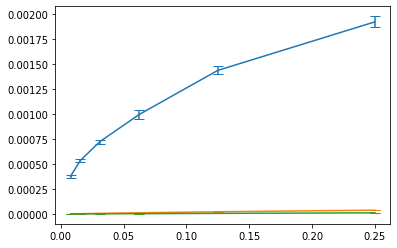

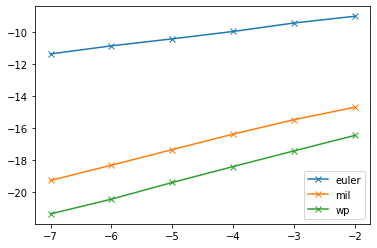

In [7]:
table_euler = end_errors[0].mean(axis=-1).T
table_milstein = end_errors[1].mean(axis=-1).T
table_wp = end_errors[2].mean(axis=-1).T

mu_euler = table_euler.mean(axis=0)
sd_euler = table_euler.std(axis=0)/np.sqrt(n_wieners_per_cell)

mu_milstein = table_milstein.mean(axis=0)
sd_milstein = table_milstein.std(axis=0)/np.sqrt(n_wieners_per_cell)

mu_wp = table_wp.mean(axis=0)
sd_wp = table_wp.std(axis=0)/np.sqrt(n_wieners_per_cell)

plt.errorbar(dts, mu_euler, 2*sd_euler, capsize=5)
plt.errorbar(dts, mu_milstein, 2*sd_milstein, capsize=5)
plt.errorbar(dts, mu_wp, 2*sd_wp, capsize=5)
#plt.xlim(0, 0.02)
#plt.ylim(0, 0.1)
plt.show()

plt.plot(np.log2(dts), np.log2(mu_euler), marker='x', label='euler')
plt.plot(np.log2(dts), np.log2(mu_milstein), marker='x', label='mil')
plt.plot(np.log2(dts), np.log2(mu_wp), marker='x', label='wp')
plt.legend()